In [ ]:
!pip install transformers torch

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCEWithLogitsLoss
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report, hamming_loss, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# Load Data
data = pd.read_csv('/content/labeled_healthcare_data_groq_manual - Copy.csv')

In [ ]:
# Function to ensure the label is in list format
def ensure_list_format(label):
    if isinstance(label, str):
        label = eval(label) if label.startswith('[') else [label]
    elif not isinstance(label, list):
        label = [label]
    return label

In [ ]:
import re

# Function to clean and map labels
def clean_and_map_labels(label_list):
    correct_labels = [
        "Healthcare Provider",
        "Patient",
        "Payers and Insurers",
        "Pharmaceutical Representative",
        "Regulator"
    ]

    clean_labels = []
    for label in label_list:
        cleaned_label = re.sub(r"[^\w\s]", "", label).strip()
        if cleaned_label in correct_labels:
            clean_labels.append(cleaned_label)
    return list(set(clean_labels))

In [ ]:
data['label'] = data['label'].apply(ensure_list_format)
data['label'] = data['label'].apply(clean_and_map_labels)

print(data['label'].head())

0                      [Pharmaceutical Representative]
1                                [Healthcare Provider]
2    [Healthcare Provider, Pharmaceutical Represent...
3                                          [Regulator]
4    [Healthcare Provider, Pharmaceutical Represent...
Name: label, dtype: object


In [ ]:
from itertools import chain

all_labels = list(chain.from_iterable(data['label']))
print(pd.Series(all_labels).value_counts())

Healthcare Provider              57
Regulator                        52
Pharmaceutical Representative    22
Patient                          20
Payers and Insurers               1
Name: count, dtype: int64


In [ ]:
# Multi-Label Binarization
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['label'])

In [ ]:
print(y[:5])
print(mlb.classes_)

[[0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 1 1]
 [0 0 0 0 1]
 [1 0 1 1 1]]
['Healthcare Provider' 'Patient' 'Payers and Insurers'
 'Pharmaceutical Representative' 'Regulator']


In [ ]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('tarasophia/Bio_ClinicalBERT_medical')
import re

# Preprocessing
def preprocess_text(text):
    text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

data['processed_text'] = data['text'].apply(preprocess_text)

tokenizer_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

In [ ]:
# Dataset Preparation
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], y, test_size=0.2, random_state=42)

train_dataset = MultiLabelDataset(X_train.tolist(), y_train, tokenizer, max_len=128)
test_dataset = MultiLabelDataset(X_test.tolist(), y_test, tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
import torch.optim as optim

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=y.shape[1], problem_type="multi_label_classification")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

class_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class_weights = class_weights.reshape(-1, 1).repeat(1, y_train.shape[1])
class_weights = class_weights.mean(axis=0)

In [ ]:
from torch.nn import BCEWithLogitsLoss

# loss function with class weights
criterion = BCEWithLogitsLoss(pos_weight=class_weights)

In [ ]:
# Training Function
def train_epoch(model, data_loader, optimizer, device, criterion):
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()

        # Extract inputs and labels
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=None)
        logits = outputs.logits

        # Compute weighted loss
        loss = criterion(logits, labels)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader)


In [ ]:
def eval_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Compute weighted loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    return avg_loss, np.array(all_preds), np.array(all_labels)

In [ ]:
# Training Loop
epochs = 9
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device, criterion)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}")


Epoch 1/9, Loss: 0.6305
Epoch 2/9, Loss: 0.5752
Epoch 3/9, Loss: 0.5338
Epoch 4/9, Loss: 0.5160
Epoch 5/9, Loss: 0.4979
Epoch 6/9, Loss: 0.4763
Epoch 7/9, Loss: 0.4737
Epoch 8/9, Loss: 0.4620
Epoch 9/9, Loss: 0.4453


In [ ]:
# Evaluation
avg_loss, preds, labels = eval_model(model, test_loader, device, criterion)
preds_binary = (preds >= 0.2).astype(int)

print("Classification Report:")
print(classification_report(labels, preds_binary, target_names=mlb.classes_, zero_division=0))
print("Hamming Loss:", hamming_loss(labels, preds_binary))
print("F1 Score (Micro):", f1_score(labels, preds_binary, average="micro"))
print(f"Average Loss: {avg_loss:.4f}")

Classification Report:
                               precision    recall  f1-score   support

          Healthcare Provider       0.55      1.00      0.71        12
                      Patient       0.17      0.50      0.25         2
          Payers and Insurers       0.00      0.00      0.00         1
Pharmaceutical Representative       0.23      1.00      0.37         5
                    Regulator       0.55      1.00      0.71        12

                    micro avg       0.42      0.94      0.58        32
                    macro avg       0.30      0.70      0.41        32
                 weighted avg       0.46      0.94      0.60        32
                  samples avg       0.43      0.94      0.55        32

Hamming Loss: 0.4
F1 Score (Micro): 0.5769230769230769
Average Loss: 0.4537


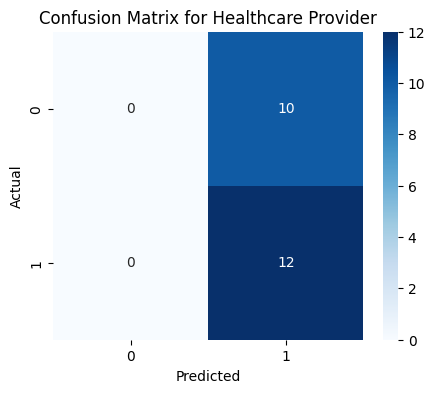

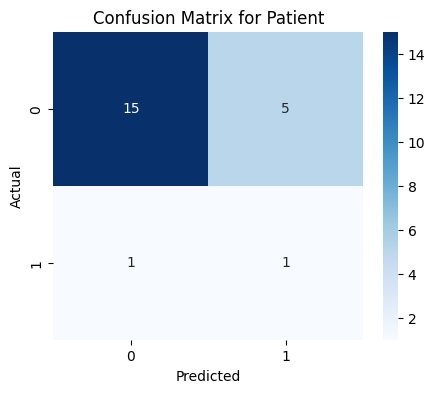

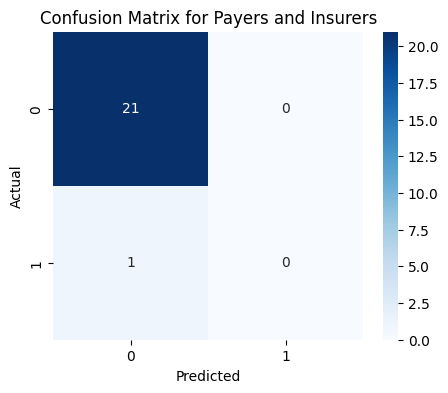

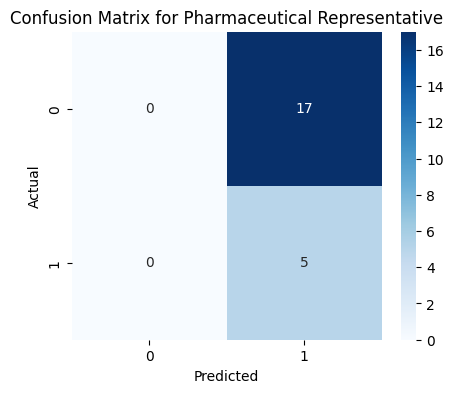

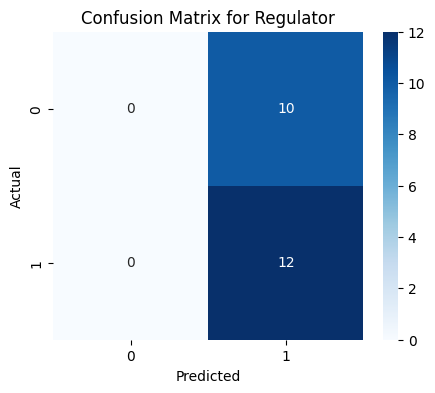

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = multilabel_confusion_matrix(labels, preds_binary)

label_names = mlb.classes_

for i, class_name in enumerate(label_names):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {class_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
# Save the Model and Tokenizer
model.save_pretrained("multi_label_bert_model/")
tokenizer.save_pretrained("multi_label_tokenizer/")

('multi_label_tokenizer/tokenizer_config.json',
 'multi_label_tokenizer/special_tokens_map.json',
 'multi_label_tokenizer/vocab.txt',
 'multi_label_tokenizer/added_tokens.json')

In [ ]:
!pip install dagshub mlflow

In [ ]:
import mlflow
import mlflow.transformers
import mlflow.sklearn

In [ ]:
import dagshub
dagshub.init(repo_owner='8banerjee', repo_name='innate_ml', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=a398c960-4ed2-4f80-ae04-f34a95198b7c&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=aac3941e588ac52fb88c2d2532c5279c831059dff69c8beae13464be2011263a




Accessing as Innate-Joint-Account

Initialized MLflow to track repo "8banerjee/innate_ml"

Repository 8banerjee/innate_ml initialized!

In [ ]:
import os
os.environ['MLFLOW_TRACKING_USERNAME'] = 'weneedtoworktogether8@gmail.com'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'weneedtoworktogether@123'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/8banerjee/innate_ml.mlflow'

In [ ]:
mlflow.set_experiment("multilabel_actor_classification")

<Experiment: artifact_location='mlflow-artifacts:/0755ffde7e6b4ec08129a8cdd2b51748', creation_time=1733915208992, experiment_id='10', last_update_time=1733915208992, lifecycle_stage='active', name='multilabel_actor_classification', tags={}>

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_and_save_confusion_matrix(y_true, y_pred, label, class_name):
    cm = confusion_matrix(y_true[:, label], y_pred[:, label])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Present", "Present"],
                yticklabels=["Not Present", "Present"])
    plt.title(f"Confusion Matrix - {class_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    file_name = f"confusion_matrix_{class_name}.png"
    plt.savefig(file_name)
    plt.close()
    return file_name

In [ ]:
from sklearn.metrics import f1_score, hamming_loss, classification_report

class_labels = [
        "Healthcare Provider",
        "Patient",
        "Payers and Insurers",
        "Pharmaceutical Representative",
        "Regulator"
    ]

def calculate_metrics(y_true, y_pred):
    f1_micro = f1_score(y_true, y_pred, average="micro")
    f1_macro = f1_score(y_true, y_pred, average="macro")
    hamming = hamming_loss(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

    return f1_micro, hamming, report

In [ ]:
with mlflow.start_run(run_name="actor_classification_manual_01"):
    mlflow.log_param("model_type", "multilabel")
    mlflow.log_param("epochs", 10)

    y_true = data['label'].apply(lambda labels: [1 if label in labels else 0 for label in class_labels]).tolist()
    y_true = np.array(y_true)

    y_true_test = y_true[X_test.index]

    f1_micro, hamming, report = calculate_metrics(y_true_test, preds_binary)
    mlflow.log_metric("f1_micro", f1_micro)
    mlflow.log_metric("hamming_loss", hamming)

    import json
    with open("classification_report.json", "w") as f:
        json.dump(report, f)
    mlflow.log_artifact("classification_report.json")


    for i, class_name in enumerate(class_labels):
        file_name = plot_and_save_confusion_matrix(y_true_test, preds_binary, i, class_name)
        mlflow.log_artifact(file_name)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🏃 View run actor_classification_manual_01 at: https://dagshub.com/8banerjee/innate_ml.mlflow/#/experiments/10/runs/c6b71de2d55949e7baf67a0e238a9149
🧪 View experiment at: https://dagshub.com/8banerjee/innate_ml.mlflow/#/experiments/10
